In [ ]:
experiment_number = 'ConvNeXt + InceptionV3 + RGB Weights' ### 자기 실험 번호 입력

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm ptflops

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import scipy.io
import timm
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from ptflops import get_model_complexity_info
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
!pip install torchprofile
from torchprofile import profile_macs

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data_dir = '/content/drive/MyDrive/심층신경망개론/'

In [ ]:
import scipy.io

setid = scipy.io.loadmat(os.path.join(data_dir, 'setid.mat'))
labels = scipy.io.loadmat(os.path.join(data_dir, 'imagelabels.mat'))

train_ids = setid['trnid'][0]
valid_ids = setid['valid'][0]
test_ids = setid['tstid'][0]
image_labels = labels['labels'][0]

In [ ]:
class OxfordFlowersDataset(Dataset):

    def __init__(self, image_ids, labels, root_dir, transform=None):
        self.image_ids = image_ids
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.root_dir, 'jpg', f'image_{img_id:05d}.jpg')
        image = Image.open(img_path).convert('RGB')
        label = self.labels[img_id - 1] - 1

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(299, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = OxfordFlowersDataset(
    image_ids=train_ids,
    labels=image_labels,
    root_dir=data_dir,
    transform=train_transforms
)

valid_dataset = OxfordFlowersDataset(
    image_ids=valid_ids,
    labels=image_labels,
    root_dir=data_dir,
    transform=val_test_transforms
)

test_dataset = OxfordFlowersDataset(
    image_ids=test_ids,
    labels=image_labels,
    root_dir=data_dir,
    transform=val_test_transforms
)

batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [ ]:
inception = models.inception_v3(pretrained=True)
inception.aux_logits = False
in_features_inception = inception.fc.in_features
inception.fc = nn.Identity()

convnext = models.convnext_tiny(pretrained=True)
in_features_convnext = convnext.classifier[2].in_features
convnext.classifier[2] = nn.Identity()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inception = inception.to(device)
convnext = convnext.to(device)

class CombinedModel(nn.Module):
    def __init__(self, inception, convnext, num_classes=102):
        super(CombinedModel, self).__init__()
        self.inception = inception
        self.convnext = convnext
        self.fc1 = nn.Linear(in_features_inception + in_features_convnext, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.745093574409461)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        f1 = self.inception(x)
        f2 = self.convnext(x)
        f = torch.cat([f1, f2], dim=1)
        f = self.fc1(f)
        f = self.bn1(f)
        f = self.relu(f)
        f = self.dropout(f)
        out = self.fc2(f)
        return out

model = CombinedModel(inception, convnext, num_classes=102).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 214MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated sin

In [ ]:
dummy_input = torch.randn(1, 3, 299, 299).to(device)
flops = profile_macs(model, dummy_input)
print(f"FLOPs: {flops / 1e9:.4f} GFLOPs")

FLOPs: 9.6820 GFLOPs


/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::gelu". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


In [ ]:
with torch.cuda.device(0):
    macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                             print_per_layer_stat=False, verbose=False)
    print(f"GFLOPs: {macs}")

GFLOPs: 7.34 GMac


In [ ]:
criterion = nn.CrossEntropyLoss()

for param in model.inception.parameters():
    param.requires_grad = False
for param in model.convnext.parameters():
    param.requires_grad = False

trainable_params = list(model.fc1.parameters()) + \
                   list(model.bn1.parameters()) + \
                   list(model.fc2.parameters())

optimizer = torch.optim.AdamW(trainable_params, lr=0.0015240807648509965, weight_decay=3.432597361947343e-05)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    verbose=True,
    threshold=1e-4,
    threshold_mode='rel'
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()
num_epochs = 20
patience = 3
best_val_loss = float('inf')
trigger_times = 0
unfreeze_epoch = 5

<ipython-input-14-e52125fc2efc>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
save_dir = f'/content/drive/MyDrive/심층신경망개론/model/'
os.makedirs(save_dir, exist_ok=True)

final_model_path = os.path.join(save_dir, f'{experiment_number}_model.pth')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

r_weight = 1.2
g_weight = 0.9
b_weight = 0.9

for epoch in range(num_epochs):
    if epoch == unfreeze_epoch:
        for param in model.inception.parameters():
            param.requires_grad = True
        for param in model.convnext.parameters():
            param.requires_grad = True
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
        print(f"Unfrozen base layers at epoch: {epoch+1}")

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs[:, 0, :, :] *= r_weight
        inputs[:, 1, :, :] *= g_weight
        inputs[:, 2, :, :] *= b_weight
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        train_bar.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%')

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    all_preds = []
    all_labels_list = []

    val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation")
    with torch.no_grad():
        for val_inputs, val_labels in val_bar:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            val_inputs[:, 0, :, :] *= r_weight
            val_inputs[:, 1, :, :] *= g_weight
            val_inputs[:, 2, :, :] *= b_weight

            with autocast():
                val_outputs = model(val_inputs)
                val_loss_batch = criterion(val_outputs, val_labels)

            val_loss += val_loss_batch.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

            all_preds.extend(val_predicted.cpu().numpy())
            all_labels_list.extend(val_labels.cpu().numpy())

            val_bar.set_postfix(loss=val_loss_batch.item(), accuracy=100 * val_correct / val_total)

    val_epoch_loss = val_loss / len(valid_dataset)
    val_epoch_acc = 100 * val_correct / val_total

    val_accuracy = accuracy_score(all_labels_list, all_preds)
    val_precision = precision_score(all_labels_list, all_preds, average='macro')
    val_recall = recall_score(all_labels_list, all_preds, average='macro')
    val_f1 = f1_score(all_labels_list, all_preds, average='macro')

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.2f}%')
    print(f'Validation Precision: {val_precision:.4f}')
    print(f'Validation Recall: {val_recall:.4f}')
    print(f'Validation F1-Score: {val_f1:.4f}\n')

    scheduler.step(val_epoch_loss)

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        print(f'EarlyStopping counter: {trigger_times} out of {patience}\n')
        if trigger_times >= patience:
            print('Early stopping!\n')
            break

print("Training completed.")

Epoch 1/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/20 Training: 100%|██████████| 32/32 [04:06<00:00,  7.70s/it, accuracy=11.5, loss=3.62]


Epoch [1/20], Train Loss: 4.1673, Train Accuracy: 11.47%


Epoch 1/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/20 Validation: 100%|██████████| 32/32 [03:35<00:00,  6.75s/it, accuracy=62.8, loss=1.82]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 2.5125, Validation Accuracy: 62.84%
Validation Precision: 0.6507
Validation Recall: 0.6284
Validation F1-Score: 0.5825



Epoch 2/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/20 Training: 100%|██████████| 32/32 [00:03<00:00,  8.94it/s, accuracy=48.1, loss=2.63]


Epoch [2/20], Train Loss: 2.3916, Train Accuracy: 48.14%


Epoch 2/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.63it/s, accuracy=80.4, loss=1.36]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 1.5381, Validation Accuracy: 80.39%
Validation Precision: 0.8302
Validation Recall: 0.8039
Validation F1-Score: 0.7917



Epoch 3/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/20 Training: 100%|██████████| 32/32 [00:03<00:00,  8.63it/s, accuracy=67.6, loss=1.52]


Epoch [3/20], Train Loss: 1.5423, Train Accuracy: 67.65%


Epoch 3/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  9.24it/s, accuracy=85.6, loss=0.87]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 1.0792, Validation Accuracy: 85.59%
Validation Precision: 0.8603
Validation Recall: 0.8559
Validation F1-Score: 0.8490



Epoch 4/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/20 Training: 100%|██████████| 32/32 [00:04<00:00,  7.65it/s, accuracy=79.9, loss=0.882]


Epoch [4/20], Train Loss: 1.0734, Train Accuracy: 79.90%


Epoch 4/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.96it/s, accuracy=89.8, loss=0.719]


Validation Loss: 0.8236, Validation Accuracy: 89.80%
Validation Precision: 0.9132
Validation Recall: 0.8980
Validation F1-Score: 0.8970



Epoch 5/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/20 Training: 100%|██████████| 32/32 [00:04<00:00,  7.85it/s, accuracy=83.4, loss=0.687]


Epoch [5/20], Train Loss: 0.8072, Train Accuracy: 83.43%


Epoch 5/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.97it/s, accuracy=90.2, loss=0.678]


Validation Loss: 0.6761, Validation Accuracy: 90.20%
Validation Precision: 0.9138
Validation Recall: 0.9020
Validation F1-Score: 0.9015

Unfrozen base layers at epoch: 6


Epoch 6/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/20 Training: 100%|██████████| 32/32 [00:06<00:00,  5.33it/s, accuracy=90, loss=0.348]


Epoch [6/20], Train Loss: 0.6071, Train Accuracy: 90.00%


Epoch 6/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  9.15it/s, accuracy=91.3, loss=0.537]


Validation Loss: 0.5921, Validation Accuracy: 91.27%
Validation Precision: 0.9220
Validation Recall: 0.9127
Validation F1-Score: 0.9120



Epoch 7/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/20 Training: 100%|██████████| 32/32 [00:05<00:00,  5.86it/s, accuracy=90.3, loss=0.523]


Epoch [7/20], Train Loss: 0.5311, Train Accuracy: 90.29%


Epoch 7/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  9.05it/s, accuracy=92, loss=0.562]


Validation Loss: 0.5758, Validation Accuracy: 91.96%
Validation Precision: 0.9290
Validation Recall: 0.9196
Validation F1-Score: 0.9189



Epoch 8/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/20 Training: 100%|██████████| 32/32 [00:05<00:00,  6.33it/s, accuracy=91.5, loss=0.448]


Epoch [8/20], Train Loss: 0.5151, Train Accuracy: 91.47%


Epoch 8/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.80it/s, accuracy=92, loss=0.52]


Validation Loss: 0.5507, Validation Accuracy: 91.96%
Validation Precision: 0.9277
Validation Recall: 0.9196
Validation F1-Score: 0.9183



Epoch 9/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/20 Training: 100%|██████████| 32/32 [00:05<00:00,  6.20it/s, accuracy=93.1, loss=0.396]


Epoch [9/20], Train Loss: 0.4693, Train Accuracy: 93.14%


Epoch 9/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.92it/s, accuracy=92.5, loss=0.483]


Validation Loss: 0.5329, Validation Accuracy: 92.55%
Validation Precision: 0.9341
Validation Recall: 0.9255
Validation F1-Score: 0.9252



Epoch 10/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/20 Training: 100%|██████████| 32/32 [00:05<00:00,  5.81it/s, accuracy=93.8, loss=0.286]


Epoch [10/20], Train Loss: 0.4223, Train Accuracy: 93.82%


Epoch 10/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.87it/s, accuracy=92.9, loss=0.458]


Validation Loss: 0.5186, Validation Accuracy: 92.94%
Validation Precision: 0.9378
Validation Recall: 0.9294
Validation F1-Score: 0.9288



Epoch 11/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/20 Training: 100%|██████████| 32/32 [00:05<00:00,  5.99it/s, accuracy=95.6, loss=0.327]


Epoch [11/20], Train Loss: 0.3989, Train Accuracy: 95.59%


Epoch 11/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.72it/s, accuracy=92.9, loss=0.438]


Validation Loss: 0.5108, Validation Accuracy: 92.94%
Validation Precision: 0.9382
Validation Recall: 0.9294
Validation F1-Score: 0.9290



Epoch 12/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/20 Training: 100%|██████████| 32/32 [00:05<00:00,  6.03it/s, accuracy=94, loss=0.384]


Epoch [12/20], Train Loss: 0.4023, Train Accuracy: 94.02%


Epoch 12/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  9.17it/s, accuracy=93, loss=0.413]


Validation Loss: 0.4959, Validation Accuracy: 93.04%
Validation Precision: 0.9389
Validation Recall: 0.9304
Validation F1-Score: 0.9297



Epoch 13/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/20 Training: 100%|██████████| 32/32 [00:05<00:00,  5.96it/s, accuracy=94.7, loss=0.515]


Epoch [13/20], Train Loss: 0.3808, Train Accuracy: 94.71%


Epoch 13/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  9.14it/s, accuracy=93.5, loss=0.372]


Validation Loss: 0.4851, Validation Accuracy: 93.53%
Validation Precision: 0.9431
Validation Recall: 0.9353
Validation F1-Score: 0.9348



Epoch 14/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/20 Training: 100%|██████████| 32/32 [00:05<00:00,  5.91it/s, accuracy=96.1, loss=0.51]


Epoch [14/20], Train Loss: 0.3529, Train Accuracy: 96.08%


Epoch 14/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.83it/s, accuracy=93.2, loss=0.394]


Validation Loss: 0.4786, Validation Accuracy: 93.24%
Validation Precision: 0.9404
Validation Recall: 0.9324
Validation F1-Score: 0.9317



Epoch 15/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/20 Training: 100%|██████████| 32/32 [00:05<00:00,  6.04it/s, accuracy=95.2, loss=0.392]


Epoch [15/20], Train Loss: 0.3474, Train Accuracy: 95.20%


Epoch 15/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.52it/s, accuracy=93.6, loss=0.379]


Validation Loss: 0.4687, Validation Accuracy: 93.63%
Validation Precision: 0.9432
Validation Recall: 0.9363
Validation F1-Score: 0.9356



Epoch 16/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16/20 Training: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s, accuracy=96.6, loss=0.588]


Epoch [16/20], Train Loss: 0.3197, Train Accuracy: 96.57%


Epoch 16/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  9.05it/s, accuracy=93.6, loss=0.4]


Validation Loss: 0.4612, Validation Accuracy: 93.63%
Validation Precision: 0.9438
Validation Recall: 0.9363
Validation F1-Score: 0.9352



Epoch 17/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17/20 Training: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s, accuracy=96.6, loss=0.279]


Epoch [17/20], Train Loss: 0.2872, Train Accuracy: 96.57%


Epoch 17/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  9.24it/s, accuracy=93.9, loss=0.363]


Validation Loss: 0.4539, Validation Accuracy: 93.92%
Validation Precision: 0.9460
Validation Recall: 0.9392
Validation F1-Score: 0.9383



Epoch 18/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18/20 Training: 100%|██████████| 32/32 [00:05<00:00,  5.96it/s, accuracy=96.7, loss=0.239]


Epoch [18/20], Train Loss: 0.2862, Train Accuracy: 96.67%


Epoch 18/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  8.69it/s, accuracy=93.7, loss=0.355]


Validation Loss: 0.4504, Validation Accuracy: 93.73%
Validation Precision: 0.9448
Validation Recall: 0.9373
Validation F1-Score: 0.9367



Epoch 19/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19/20 Training: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s, accuracy=97.3, loss=0.189]


Epoch [19/20], Train Loss: 0.2815, Train Accuracy: 97.25%


Epoch 19/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  9.08it/s, accuracy=93.7, loss=0.347]


Validation Loss: 0.4383, Validation Accuracy: 93.73%
Validation Precision: 0.9451
Validation Recall: 0.9373
Validation F1-Score: 0.9366



Epoch 20/20 Training:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20/20 Training: 100%|██████████| 32/32 [00:05<00:00,  5.97it/s, accuracy=97.4, loss=0.402]


Epoch [20/20], Train Loss: 0.2620, Train Accuracy: 97.35%


Epoch 20/20 Validation:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-ccc9b0848988>:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20/20 Validation: 100%|██████████| 32/32 [00:03<00:00,  9.10it/s, accuracy=94.1, loss=0.374]


Validation Loss: 0.4305, Validation Accuracy: 94.12%
Validation Precision: 0.9482
Validation Recall: 0.9412
Validation F1-Score: 0.9407

Training completed.


<ipython-input-16-d106ab3010ac>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(final_model_path))


Error loading the final model: Error(s) in loading state_dict for CombinedModel:
	Missing key(s) in state_dict: "fc1.weight", "fc1.bias", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "fc2.weight", "fc2.bias". 
	Unexpected key(s) in state_dict: "p", "proj_inception.weight", "proj_inception.bias", "proj_convnext.weight", "proj_convnext.bias", "fc.weight", "fc.bias". 


Testing:   0%|          | 0/193 [00:00<?, ?it/s]<ipython-input-16-d106ab3010ac>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing: 100%|██████████| 193/193 [21:30<00:00,  6.69s/it, accuracy=88.18%, loss=0.129, top5_accuracy=96.93%]


Test Loss: 0.4807, Top-1 Accuracy: 88.18%, Top-5 Accuracy: 96.93%
Test Precision: 0.8785
Test Recall: 0.9063
Test F1-Score: 0.8831


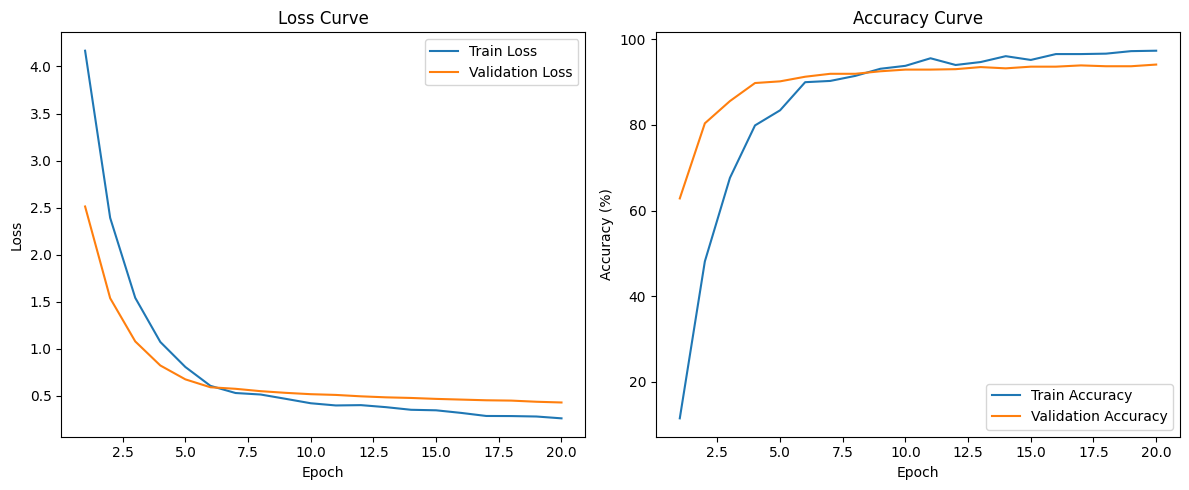

[4.16730622216767, 2.3915589285831826, 1.5422713602290434, 1.0733700635386447, 0.8072087603456833, 0.607090321709128, 0.5310527920722962, 0.5151382406552633, 0.46929189142058875, 0.42225931076442497, 0.3989424499810911, 0.4023298161871293, 0.38078086820303225, 0.35293263243693934, 0.3473890426112156, 0.31971917129030414, 0.28720534771096473, 0.2861600264614704, 0.2815312367443945, 0.2620243999303556]
[11.470588235294118, 48.13725490196079, 67.6470588235294, 79.90196078431373, 83.43137254901961, 90.0, 90.29411764705883, 91.47058823529412, 93.13725490196079, 93.82352941176471, 95.58823529411765, 94.01960784313725, 94.70588235294117, 96.07843137254902, 95.19607843137256, 96.56862745098039, 96.56862745098039, 96.66666666666667, 97.25490196078431, 97.3529411764706]
[2.512492623983645, 1.5380657270842908, 1.079240266715779, 0.8236345737588172, 0.6760756955427282, 0.5921090369131051, 0.5757914643661649, 0.5506994081478492, 0.5328713942976558, 0.5185839462514017, 0.5108008496901568, 0.49588946

In [ ]:
from sklearn.metrics import top_k_accuracy_score

try:
    model.load_state_dict(torch.load(final_model_path))
    print(f'Loaded final model from {final_model_path}')
except Exception as e:
    print(f'Error loading the final model: {e}')

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

test_correct_top5 = 0

test_all_preds = []
test_all_labels = []
test_all_probs = []

with torch.no_grad():
    test_bar = tqdm(test_loader, desc="Testing")

    for test_inputs, test_labels in test_bar:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)

        with autocast():
            test_outputs = model(test_inputs)
            test_loss_batch = criterion(test_outputs, test_labels)

        test_loss += test_loss_batch.item() * test_inputs.size(0)

        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

        top5_probs, top5_predicted = torch.topk(test_outputs, 5, dim=1)
        test_correct_top5 += torch.sum(top5_predicted.eq(test_labels.view(-1, 1).expand_as(top5_predicted))).item()

        test_all_preds.extend(test_predicted.cpu().numpy())
        test_all_labels.extend(test_labels.cpu().numpy())

        test_all_probs.extend(torch.softmax(test_outputs, dim=1).cpu().numpy())

        current_accuracy = 100 * test_correct / test_total
        current_top5_accuracy = 100 * test_correct_top5 / test_total
        test_bar.set_postfix(loss=test_loss_batch.item(),
                             accuracy=f"{current_accuracy:.2f}%",
                             top5_accuracy=f"{current_top5_accuracy:.2f}%")

test_epoch_loss = test_loss / len(test_dataset)
test_epoch_acc = 100 * test_correct / test_total
test_epoch_top5_acc = 100 * test_correct_top5 / test_total

test_accuracy = accuracy_score(test_all_labels, test_all_preds)
test_precision = precision_score(test_all_labels, test_all_preds, average='macro')
test_recall = recall_score(test_all_labels, test_all_preds, average='macro')
test_f1 = f1_score(test_all_labels, test_all_preds, average='macro')

print('Test Loss: {:.4f}, Top-1 Accuracy: {:.2f}%, Top-5 Accuracy: {:.2f}%'.format(
    test_epoch_loss, test_epoch_acc, test_epoch_top5_acc))
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(train_losses)
print(train_accuracies)
print(val_losses)
print(val_accuracies)